In [1]:
import torch
import numpy as np
import pandas as pd

In [2]:
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS
from Envs.env_stocktrading import StockTradingEnv

## Read data

We first read the .csv file of our training data into dataframe.

In [3]:
train = pd.read_csv(r"C:\Users\potap\OneDrive\Desktop\hourly\hourly_smoothed_training_data.csv")#'Data/Hourly/hourly_smoothed_training_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following two lines.
def prep(train):
    # Sort the DataFrame by the 'date' column
    train = train.sort_values(by='date')

    # Create a mapping of unique dates to their corresponding index
    date_mapping = {date: idx for idx, date in enumerate(train['date'].unique())}

    # Map the 'date' column to the date_mapping to get the new index
    train['index'] = train['date'].map(date_mapping)

    # Set the new index for the DataFrame
    train.set_index('index', inplace=True, drop=True)
    train = train.fillna(0)
    return train

train = prep(train)

In [4]:
train

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,close_30_sma,close_60_sma,turbulence,vix,stocktwitsPosts,stocktwitsLikes,stocktwitsImpressions,stocktwitsSentiment,random,change
index,,,,,,,,,,,,,,,,,,,,,
0,2021-11-24 14:00:00,159.380,159.703,158.862,159.233753,3513469.0,AAPL,5,0.000000,159.354924,...,159.233753,159.233753,0.000000,85.622,102.000000,132.0,361612.000000,0.532856,0.931294,0.000000
0,2021-11-24 14:00:00,62.865,62.988,62.693,62.666161,502837.0,C,5,0.000000,159.354924,...,62.666161,62.666161,0.000000,85.622,0.000000,0.0,0.000000,0.405170,0.098625,-0.925196
0,2021-11-24 14:00:00,158.451,158.655,158.097,158.066817,328534.0,JPM,5,0.000000,159.354924,...,158.066817,158.066817,0.000000,85.622,4.000000,3.0,88331.000000,0.427115,0.286685,-0.872143
0,2021-11-24 14:00:00,379.350,379.789,377.857,378.100817,78441.0,GS,5,0.000000,159.354924,...,378.100817,378.100817,0.000000,85.622,1.000000,0.0,1.000000,0.376175,0.370798,0.953154
0,2021-11-24 14:00:00,145.744,146.249,145.587,145.766671,329860.0,GOOGL,5,0.000000,159.354924,...,145.766671,145.766671,0.000000,85.622,2.000000,2.0,279.000000,0.485056,0.873345,-0.033662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2481,2023-04-26 10:00:00,59.444,59.938,59.362,59.999467,1496473.0,MU,1,-0.554974,61.618781,...,60.115730,60.957669,6584.348552,42.076,0.000000,0.0,0.000000,0.000000,0.999259,-1.129730
2481,2023-04-26 10:00:00,186.561,186.758,185.602,185.687607,153780.0,PEP,1,1.082269,188.327078,...,184.075255,182.828626,6584.348552,42.076,1.000000,0.0,35848.666667,0.500000,0.301655,0.804431
2481,2023-04-26 10:00:00,63.061,63.226,62.975,63.098375,604614.0,KO,1,-0.024870,63.893948,...,63.424252,63.126427,6584.348552,42.076,1.000000,0.0,10196.000000,0.546800,0.223712,-0.757135


In [5]:
def prep(train):
    # Sort the DataFrame by the 'date' column
    train = train.sort_values(by='date')

    # Create a mapping of unique dates to their corresponding index
    date_mapping = {date: idx for idx, date in enumerate(train['date'].unique())}

    # Map the 'date' column to the date_mapping to get the new index
    train['index'] = train['date'].map(date_mapping)

    # Set the new index for the DataFrame
    train.set_index('index', inplace=True, drop=True)
    train = train.fillna(0)
    train = train.sort_values(['date', 'tic'], ascending=[True, True])
    return train

def normalize_data(train):
    interm = train['close']
    df_num = train.select_dtypes(include='number')
    df_norm = (df_num - df_num.min()) / (df_num.max() - df_num.min()) * 200 + 20

    train[df_norm.columns] = df_norm
    train['close'] = interm
    return train

In [6]:
train = prep(train)
train = normalize_data(train)

In [7]:
train

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,close_30_sma,close_60_sma,turbulence,vix,stocktwitsPosts,stocktwitsLikes,stocktwitsImpressions,stocktwitsSentiment,random,change
index,,,,,,,,,,,,,,,,,,,,,
0,2021-11-24 14:00:00,64.016138,63.988587,64.138571,159.233753,36.200417,AAPL,186.666667,165.712679,63.525899,...,64.562223,64.515546,20.000000,161.582472,42.666667,50.877193,47.542370,126.571143,206.266471,118.382430
0,2021-11-24 14:00:00,49.376149,49.322906,49.493062,110.897464,21.165597,ABBV,186.666667,165.712679,63.525899,...,49.711072,49.659935,20.000000,161.582472,20.444444,20.000000,20.683355,92.236713,31.638341,112.125749
0,2021-11-24 14:00:00,52.427054,52.350428,52.504564,121.101881,20.529550,ABT,186.666667,165.712679,63.525899,...,52.846342,52.796147,20.000000,161.582472,20.000000,20.000000,20.000076,75.265056,28.182841,86.437449
0,2021-11-24 14:00:00,62.882028,62.870514,62.793026,155.603433,33.684419,AMD,186.666667,165.712679,63.525899,...,63.446820,63.399809,20.000000,161.582472,40.666667,63.274854,37.499820,125.239509,157.174224,126.296812
0,2021-11-24 14:00:00,69.869048,69.887227,69.961964,178.754260,25.590194,AMZN,186.666667,165.712679,63.525899,...,70.559829,70.514953,20.000000,161.582472,29.333333,31.461988,22.481999,127.576842,72.620013,122.761487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2481,2023-04-26 10:00:00,45.337511,45.258533,45.383703,97.443876,20.509570,PM,53.333333,166.280790,45.278987,...,45.304484,45.616581,21.616267,89.575858,20.666667,20.000000,23.076317,118.000000,32.267631,83.445568
2481,2023-04-26 10:00:00,21.030981,20.989145,21.016005,17.152765,33.146380,T,53.333333,164.722635,21.112516,...,21.019897,21.254093,21.616267,89.575858,20.444444,20.000000,20.846578,145.000000,177.942358,63.538440
2481,2023-04-26 10:00:00,63.063486,62.985250,62.418756,154.644735,115.927298,TSLA,53.333333,154.443697,65.772294,...,65.603090,68.845234,21.616267,89.575858,25.555556,33.099415,21.457423,116.500000,114.807658,187.807997


Goal for generated data: one more column for sentiment for each day --> Merge on "tic" and "date"

## Construct the environment

Calculate and specify the parameters we need for constructing the environment.

In [8]:
INDICATORS = ['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma',
 'vix']

In [9]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma',
 'vix']

In [10]:
SENTIMENT = ['random', 'stocktwitsPosts', 'stocktwitsLikes', 'stocktwitsImpressions', 'stocktwitsSentiment']
#'stocktwitsPosts', 'stocktwitsLikes', 'stocktwitsImpressions', 'stocktwitsSentiment', 

In [11]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 4 * stock_dimension + len(INDICATORS) * stock_dimension + len(SENTIMENT) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 541


In [12]:
seed = 0
hourly = True

In [13]:
buy_cost_list = sell_cost_list = [0.01] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "sentiment_list": SENTIMENT,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "seed": seed,
    "hourly": hourly
}


e_train_gym = StockTradingEnv(df = train,risk_indicator_col='vix', **env_kwargs)

## Environment for training

In [14]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Get onnx model

In [15]:
saved_model_path = r"C:\Users\potap\FinARL\automatic-stock-trading-applied-reinforcement-learning-sommer-term-2023\Training_and_Testing\Evaluation\model\hourly\smoothedSentimentNorm\ppo\seed0.zip" #'Evaluation/model/hourly/smoothedSentiment/ppo/seed0.zip'

In [16]:
agent = DRLAgent(env = env_train)

In [17]:
model_a2c = agent.get_model("ppo")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device


In [18]:
trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='ppo',
                                total_timesteps=500)

541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541


In [19]:
loaded_agent = trained_a2c.load(saved_model_path)

In [20]:
# Make sure your model is in evaluation mode
loaded_agent.policy.eval()

# generate dummy input
observation_size = loaded_agent.observation_space.shape[0]
dummy_input = torch.randn(1, observation_size)

# Export the model to ONNX format
torch.onnx.export(loaded_agent.policy, dummy_input, "Policy/policy.onnx")


C:\Users\potap\FinARL\venv_10\lib\site-packages\stable_baselines3\common\distributions.py:87: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if deterministic:


============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================


In [21]:
import onnx

from onnx_tf.backend import prepare

onnx_model = onnx.load("Policy/policy.onnx")  # load onnx model
tf_rep = prepare(onnx_model)  # prepare tf representation
tf_rep.export_graph("Policy/tensorflowGraph.pb")  # export the model

C:\Users\potap\FinARL\venv_10\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


INFO:tensorflow:Assets written to: Policy/tensorflowGraph.pb\assets


INFO:tensorflow:Assets written to: Policy/tensorflowGraph.pb\assets


In [22]:
import tensorflow as tf
model_filename = "Policy/tensorflowGraph.pb"
# Load the TensorFlow model
model_loaded = tf.saved_model.load(model_filename)
model_loaded = model_loaded.signatures['serving_default']
model_loaded

<ConcreteFunction signature_wrapper(*, obs) at 0x1D69A6CF310>

#  Sensitivity test

In [23]:
# generate dummy input
#observation_size = model_loaded.observation_space.shape[0]
dummy_input = torch.randn(1, 541)

In [27]:
xs = tf.convert_to_tensor(dummy_input)

In [29]:
with tf.GradientTape() as tape:
    tape.watch(xs)
    pred = model_loaded(xs)
    grads = tape.gradient(pred, xs)

In [30]:
assert (grads is not None) # sanity check
grads = grads.numpy()
abs_grads_sum = np.sum(np.abs(grads), axis=0)


In [31]:
abs_grads_sum

array([3.5245521e+00, 2.7510297e+00, 3.0949292e+00, 9.0152580e-01,
       5.0263065e-01, 2.2704320e+00, 3.6417520e-01, 2.6724513e+00,
       4.5557737e-01, 4.9994335e-01, 2.9131956e+00, 1.6861186e+00,
       2.5519779e+00, 2.0534291e+00, 1.9657128e+00, 3.0764964e+00,
       2.0412471e+00, 4.4104867e+00, 7.1524429e-01, 1.8649721e+00,
       7.5821418e-01, 1.0098293e+00, 8.4005445e-01, 1.0576707e+00,
       9.9725074e-01, 6.1736798e-01, 2.1863048e+00, 3.8072712e+00,
       1.0011121e+00, 1.4268056e+00, 6.9120026e-01, 1.7792408e+00,
       1.5456958e+00, 1.4843444e+00, 3.4039996e+00, 4.2721472e+00,
       4.0408201e+00, 1.2913843e+00, 1.8608819e-01, 1.3618221e+00,
       1.1662924e+00, 9.2384078e-02, 8.6778480e-01, 5.4768305e-02,
       8.1337601e-01, 1.5153128e+00, 7.0294333e-01, 3.8968441e+00,
       2.8675234e+00, 6.7276645e-01, 3.2029897e-01, 1.8407183e+00,
       2.7834697e+00, 1.1811770e+00, 3.1125918e-01, 3.3579783e+00,
       2.0465851e+00, 2.4727814e+00, 9.2560893e-01, 3.8717113e

# Unsere Data

In [24]:
num_stock_shares = 30*[0]

In [25]:
train

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,close_30_sma,close_60_sma,turbulence,vix,stocktwitsPosts,stocktwitsLikes,stocktwitsImpressions,stocktwitsSentiment,random,change
index,,,,,,,,,,,,,,,,,,,,,
0,2021-11-24 14:00:00,64.016138,63.988587,64.138571,159.233753,36.200417,AAPL,186.666667,165.712679,63.525899,...,64.562223,64.515546,20.000000,161.582472,42.666667,50.877193,47.542370,126.571143,206.266471,118.382430
0,2021-11-24 14:00:00,49.376149,49.322906,49.493062,110.897464,21.165597,ABBV,186.666667,165.712679,63.525899,...,49.711072,49.659935,20.000000,161.582472,20.444444,20.000000,20.683355,92.236713,31.638341,112.125749
0,2021-11-24 14:00:00,52.427054,52.350428,52.504564,121.101881,20.529550,ABT,186.666667,165.712679,63.525899,...,52.846342,52.796147,20.000000,161.582472,20.000000,20.000000,20.000076,75.265056,28.182841,86.437449
0,2021-11-24 14:00:00,62.882028,62.870514,62.793026,155.603433,33.684419,AMD,186.666667,165.712679,63.525899,...,63.446820,63.399809,20.000000,161.582472,40.666667,63.274854,37.499820,125.239509,157.174224,126.296812
0,2021-11-24 14:00:00,69.869048,69.887227,69.961964,178.754260,25.590194,AMZN,186.666667,165.712679,63.525899,...,70.559829,70.514953,20.000000,161.582472,29.333333,31.461988,22.481999,127.576842,72.620013,122.761487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2481,2023-04-26 10:00:00,45.337511,45.258533,45.383703,97.443876,20.509570,PM,53.333333,166.280790,45.278987,...,45.304484,45.616581,21.616267,89.575858,20.666667,20.000000,23.076317,118.000000,32.267631,83.445568
2481,2023-04-26 10:00:00,21.030981,20.989145,21.016005,17.152765,33.146380,T,53.333333,164.722635,21.112516,...,21.019897,21.254093,21.616267,89.575858,20.444444,20.000000,20.846578,145.000000,177.942358,63.538440
2481,2023-04-26 10:00:00,63.063486,62.985250,62.418756,154.644735,115.927298,TSLA,53.333333,154.443697,65.772294,...,65.603090,68.845234,21.616267,89.575858,25.555556,33.099415,21.457423,116.500000,114.807658,187.807997


In [26]:
test = train.sort_values(['date', 'tic'],
              ascending = [True, True])
test

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,close_30_sma,close_60_sma,turbulence,vix,stocktwitsPosts,stocktwitsLikes,stocktwitsImpressions,stocktwitsSentiment,random,change
index,,,,,,,,,,,,,,,,,,,,,
0,2021-11-24 14:00:00,64.016138,63.988587,64.138571,159.233753,36.200417,AAPL,186.666667,165.712679,63.525899,...,64.562223,64.515546,20.000000,161.582472,42.666667,50.877193,47.542370,126.571143,206.266471,118.382430
0,2021-11-24 14:00:00,49.376149,49.322906,49.493062,110.897464,21.165597,ABBV,186.666667,165.712679,63.525899,...,49.711072,49.659935,20.000000,161.582472,20.444444,20.000000,20.683355,92.236713,31.638341,112.125749
0,2021-11-24 14:00:00,52.427054,52.350428,52.504564,121.101881,20.529550,ABT,186.666667,165.712679,63.525899,...,52.846342,52.796147,20.000000,161.582472,20.000000,20.000000,20.000076,75.265056,28.182841,86.437449
0,2021-11-24 14:00:00,62.882028,62.870514,62.793026,155.603433,33.684419,AMD,186.666667,165.712679,63.525899,...,63.446820,63.399809,20.000000,161.582472,40.666667,63.274854,37.499820,125.239509,157.174224,126.296812
0,2021-11-24 14:00:00,69.869048,69.887227,69.961964,178.754260,25.590194,AMZN,186.666667,165.712679,63.525899,...,70.559829,70.514953,20.000000,161.582472,29.333333,31.461988,22.481999,127.576842,72.620013,122.761487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2481,2023-04-26 10:00:00,45.337511,45.258533,45.383703,97.443876,20.509570,PM,53.333333,166.280790,45.278987,...,45.304484,45.616581,21.616267,89.575858,20.666667,20.000000,23.076317,118.000000,32.267631,83.445568
2481,2023-04-26 10:00:00,21.030981,20.989145,21.016005,17.152765,33.146380,T,53.333333,164.722635,21.112516,...,21.019897,21.254093,21.616267,89.575858,20.444444,20.000000,20.846578,145.000000,177.942358,63.538440
2481,2023-04-26 10:00:00,63.063486,62.985250,62.418756,154.644735,115.927298,TSLA,53.333333,154.443697,65.772294,...,65.603090,68.845234,21.616267,89.575858,25.555556,33.099415,21.457423,116.500000,114.807658,187.807997


In [27]:
train['tic'].unique()

array(['AAPL', 'ABBV', 'ABT', 'AMD', 'AMZN', 'BA', 'BABA', 'C', 'CRM',
       'DIS', 'GOOGL', 'GS', 'JPM', 'KO', 'MA', 'META', 'MO', 'MSFT',
       'MU', 'NFLX', 'NKE', 'NVDA', 'PEP', 'PFE', 'PG', 'PM', 'T', 'TSLA',
       'TSM', 'V'], dtype=object)

In [44]:
all_days_grads = []
for day in range(len((train.date.unique()))): # len((train.date.unique()))
   data = train.loc[day, :]

   state = (
    [50]
    + data.close.values.tolist()
    + num_stock_shares
    + sum(
        (
            data[tech].values.tolist()
            for tech in INDICATORS
        ),
        [],
    )
    + sum(
    (
        data[sent].values.tolist()
        for sent in SENTIMENT
    ),
    [],
)
    + data.change.values.tolist()
    + data.volume.values.tolist())

   #print(state)
   xs = tf.convert_to_tensor([state])
   with tf.GradientTape() as tape:
        tape.watch(xs)
        pred = model_loaded(xs)
        grads = tape.gradient(pred, xs)
   grads = grads.numpy()
   abs_grads_sum = np.sum(np.abs(grads), axis=0)
   all_days_grads.append(abs_grads_sum)

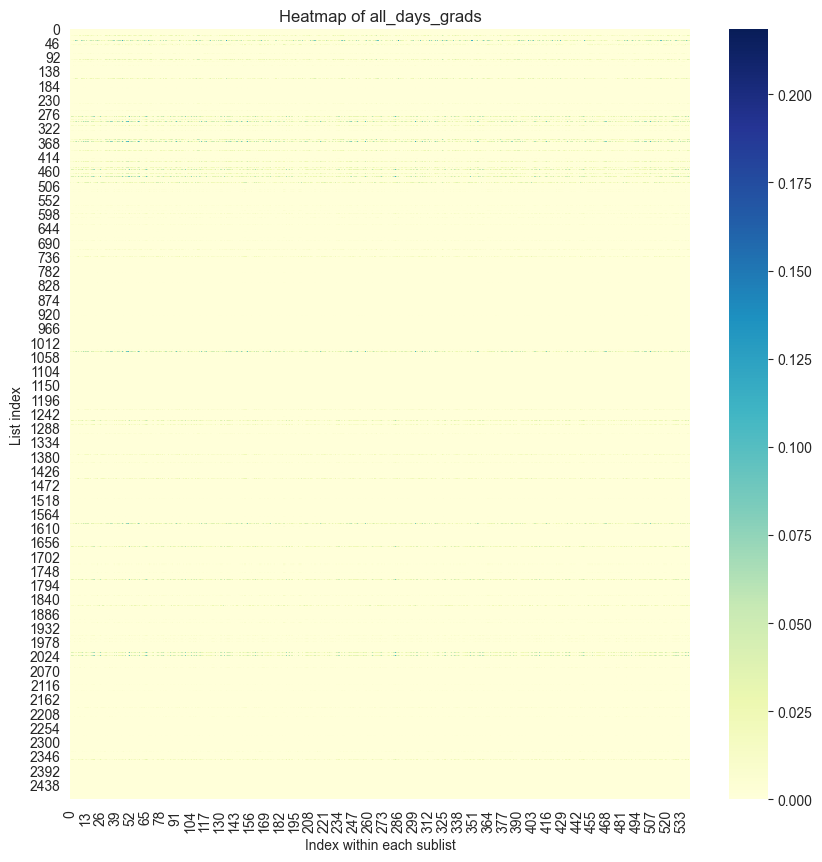

In [45]:
# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(all_days_grads, cmap="YlGnBu", cbar=True)

# Display the plot
plt.title('Heatmap of all_days_grads')
#plt.yscale("log")
plt.xlabel('Index within each sublist')
plt.ylabel('List index')
plt.savefig('Heatmap.pdf')

In [58]:
best_days = pd.DataFrame(all_days_grads)
best_days.set_index(train.date.unique(), inplace=True)
best_days['date'] = best_days.index
best_days['date'] = pd.to_datetime(best_days['date']).dt.date

In [65]:
best_days

,0,1,2,3,4,5,6,7,8,9,...,532,533,534,535,536,537,538,539,540,date
2021-11-24 14:00:00,2.595200e-05,2.133594e-05,0.000059,2.064756e-05,0.000079,0.000112,1.545742e-05,0.000090,1.870452e-05,0.000091,...,0.000108,3.650961e-05,0.000084,0.000082,0.000056,1.097325e-05,0.000100,3.080215e-05,0.000094,2021-11-24
2021-11-24 15:00:00,2.248503e-05,5.139399e-04,0.000936,4.994164e-04,0.000529,0.000419,2.078573e-04,0.000793,8.220675e-04,0.000095,...,0.000546,8.109229e-04,0.000675,0.000441,0.001983,1.625404e-04,0.000710,6.282144e-04,0.000525,2021-11-24
2021-11-26 09:00:00,1.366505e-02,1.304439e-02,0.030426,1.352260e-02,0.044972,0.057626,1.011687e-02,0.048055,1.589722e-02,0.047972,...,0.057969,1.855310e-02,0.047447,0.047157,0.032052,4.005187e-03,0.062318,7.832213e-03,0.055448,2021-11-26
2021-11-26 10:00:00,4.947735e-07,4.067685e-07,0.000001,3.936446e-07,0.000002,0.000002,2.946949e-07,0.000002,3.566007e-07,0.000002,...,0.000002,6.960536e-07,0.000002,0.000002,0.000001,2.092044e-07,0.000002,5.872413e-07,0.000002,2021-11-26
2021-11-26 11:00:00,3.941441e-03,3.240380e-03,0.009024,3.135832e-03,0.012058,0.017056,2.347585e-03,0.013669,2.840736e-03,0.013832,...,0.016431,5.544869e-03,0.012797,0.012458,0.008506,1.666554e-03,0.015173,4.678053e-03,0.014287,2021-11-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25 13:00:00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,2023-04-25
2023-04-25 14:00:00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,2023-04-25
2023-04-25 15:00:00,7.307922e-07,1.723378e-05,0.000032,1.731252e-05,0.000018,0.000015,7.319402e-06,0.000027,2.710411e-05,0.000003,...,0.000019,2.769078e-05,0.000023,0.000015,0.000067,5.784785e-06,0.000023,2.012701e-05,0.000017,2023-04-25
2023-04-26 09:00:00,1.484885e-04,1.096970e-02,0.008400,2.161722e-03,0.004958,0.005821,6.027832e-04,0.011035,6.802785e-03,0.008177,...,0.001351,6.901228e-03,0.010437,0.003939,0.015937,1.036222e-02,0.005588,1.715634e-02,0.000876,2023-04-26


# Feature impontance

In [60]:
STATE = ['Close', 'NumStocks']
INDICATORS = ['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma',
 'vix']
# later use only import INDICATORS
STATE.extend(INDICATORS)

SENTIMENT = ['random', 'stocktwitsPosts', 'stocktwitsLikes', 'stocktwitsImpressions', 'stocktwitsSentiment']
#'stocktwitsPosts', 'stocktwitsLikes', 'stocktwitsImpressions', 'stocktwitsSentiment', 

# later use only import SENTIMENT

STATE.extend(SENTIMENT)
STATE.extend(['Change', 'Volume'])

In [61]:
features = pd.DataFrame()
n = 30 
for index in range(len(STATE)):
    name = STATE[index]
    features[name] = best_days.iloc[:,1+(n*index):31+(n*index)].mean(axis=1)
print(features.mean().values)

CATEGORIES = ['Market', 'Indicators', 'Sentiment', 'Random']
# macht cats manuell

df_cats = pd.DataFrame()
df_cats['Market'] = features[['Close', 'NumStocks', 'Change', 'Volume']].mean(axis=1)
df_cats['Indicators'] = features[['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma', 'vix']].mean(axis=1)
df_cats['Sentiment'] = features[['stocktwitsPosts', 'stocktwitsLikes', 'stocktwitsImpressions','stocktwitsSentiment']].mean(axis=1)
df_cats['Random'] = features[['random']].mean(axis=1)



print(df_cats.mean().values)

[0.00103664 0.00126901 0.00103937 0.0010653  0.0010052  0.00096363
 0.00081556 0.0008574  0.00102011 0.00093481 0.00093953 0.00098264
 0.00094632 0.0009466  0.00084667 0.00078087 0.000952   0.00105404]
[0.00107792 0.0009601  0.00088011 0.00098264]


In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

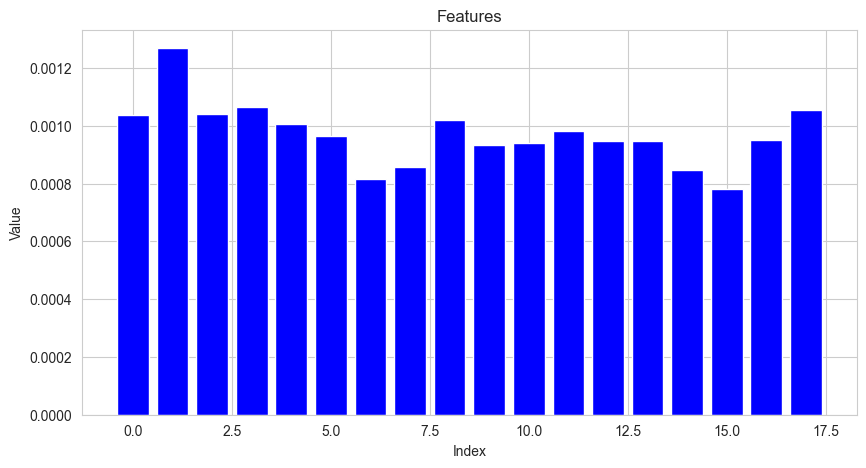

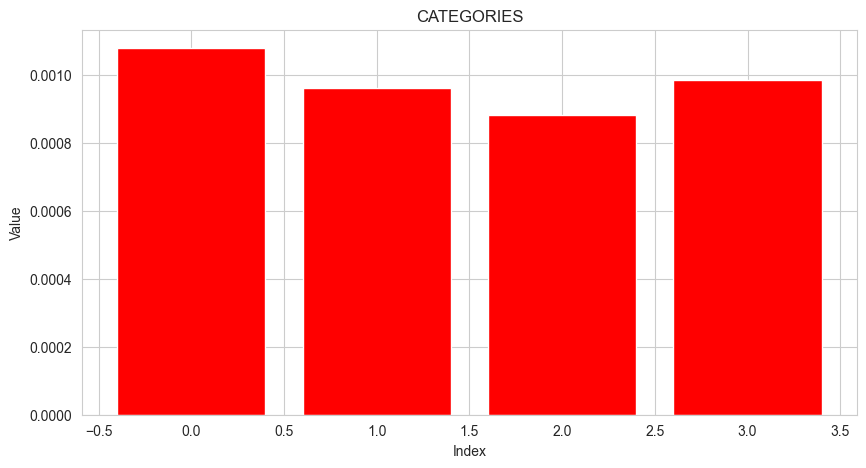

In [63]:
# Plotting the first array
plt.figure(figsize=(10, 5))
plt.bar(range(len(features.mean().values)), features.mean().values, color='blue')
plt.title("Features")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

# Plotting the second array
plt.figure(figsize=(10, 5))
plt.bar(range(len(df_cats.mean().values)), df_cats.mean().values, color='red')
plt.title("CATEGORIES")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()





# Day importance


In [98]:
df = best_days.copy()

In [99]:
# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Drop the 'date' column and sum across rows
df['total'] = df.drop('date', axis=1).sum(axis=1)

# Group by 'date' and sum the 'total' column
result = df.groupby('date')['total'].sum()

# Reset the index to get day number
result = result.reset_index()
#result['day_number'] = (result['date'] - result['date'].min()).dt.days + 1
#result.set_index('day_number', inplace=True)
result.drop('date', axis=1, inplace=True)

In [100]:
result

,total
0,0.395124
1,28.865166
2,0.606796
3,15.121608
4,13.757532
...,...
351,0.000000
352,1.538727
353,1.288594
354,0.830117


In [101]:
unique_dates = df['date'].unique()
date_mapping = pd.DataFrame({
    'date': unique_dates
}, index=range(0, len(unique_dates)))

# Join the date to the result DataFrame based on index
result = result.join(date_mapping)

In [104]:
result

,total
date,
2021-11-24,0.395124
2021-11-26,28.865166
2021-11-29,0.606796
2021-11-30,15.121608
2021-12-01,13.757532
...,...
2023-04-20,0.000000
2023-04-21,1.538727
2023-04-24,1.288594


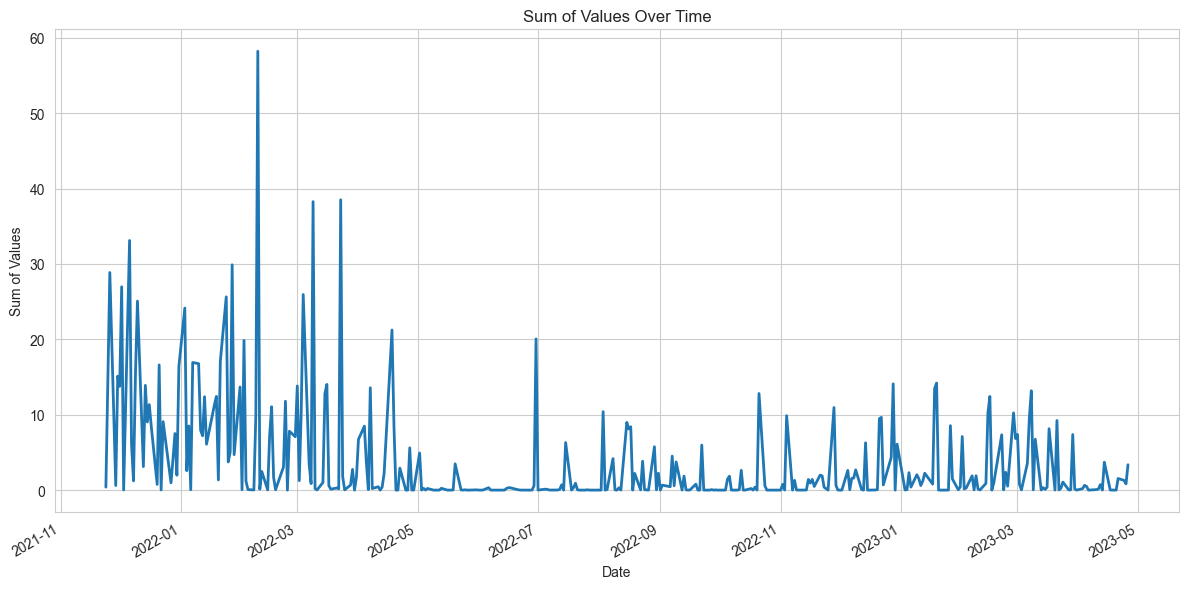

In [103]:
import matplotlib.pyplot as plt

# Set the date as the index for better plotting
result.set_index('date', inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
result['total'].plot(linewidth=2)
plt.title('Sum of Values Over Time')
plt.xlabel('Date')
plt.ylabel('Sum of Values')
plt.grid(True)
plt.tight_layout()
plt.show()

# Tics importance

In [106]:
#By Tics

len(["Stock"+str(x+1) for x in range(30)])
# hatte grad die trainingsdaten und damit unique tics nicht 

stocks = ["Stock"+str(x+1) for x in range(30)]


df = pd.DataFrame()
stocks = ["Stock"+str(x+1) for x in range(30)]
n = len(stocks) 
#for index in range(len(STATE)):
#    name = STATE[index]
#    df[name] = best_days.iloc[:,1+(n*index):31+(n*index)].mean(axis=1)
#df.mean().values


print(len(best_days.columns)-2)

print( 30*18)

"""For first Stock column indices of the df: [1, 31, 61, ...] -> len([...]) = 18


For second Stock column indices of the df: [2, 32, 62, ...]-> len([...]) = 18

...


For thirtiest Stock column indices of the df: [30, 60, 90, ...]-> len([...]) = 18
"""



n = 30#up to 30
print(list(range(n,(len(best_days.columns)-1),30)))

tics = pd.DataFrame()
stocks = ["Stock"+str(x+1) for x in range(30)]
n = len(stocks) 
for index in range(1,len(stocks)+1):
    indices = list(range(index,(len(best_days.columns)-1),30))
    name = stocks[index-1]
    tics[name] = best_days.iloc[:,indices].mean(axis=1)
print(tics.mean().values)

tics

540
540
[30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540]
[0.00097594 0.00090559 0.00087542 0.00096818 0.00110077 0.00101176
 0.00088403 0.00082416 0.00095373 0.00089575 0.00092189 0.00092605
 0.00099693 0.00088684 0.00107785 0.00102008 0.00093351 0.00093439
 0.00109384 0.00099236 0.00100797 0.0009061  0.00091573 0.001049
 0.00095797 0.00107852 0.00102685 0.00095408 0.00104119 0.00097631]


,Stock1,Stock2,Stock3,Stock4,Stock5,Stock6,Stock7,Stock8,Stock9,Stock10,...,Stock21,Stock22,Stock23,Stock24,Stock25,Stock26,Stock27,Stock28,Stock29,Stock30
2021-11-24 14:00:00,0.000059,0.000055,5.077816e-05,0.000065,0.000060,0.000062,4.796496e-05,4.183903e-05,0.000056,4.728489e-05,...,0.000053,0.000058,4.949013e-05,0.000070,0.000076,0.000064,4.449334e-05,0.000061,0.000056,4.748092e-05
2021-11-24 15:00:00,0.000546,0.000797,5.134891e-04,0.000761,0.000658,0.000679,6.755108e-04,9.521728e-04,0.000686,6.725992e-04,...,0.000569,0.000770,7.542418e-04,0.000736,0.000496,0.000586,5.551158e-04,0.000693,0.000730,6.402498e-04
2021-11-26 09:00:00,0.032247,0.031330,2.669036e-02,0.035039,0.032447,0.034594,2.699015e-02,2.391502e-02,0.031956,2.563231e-02,...,0.028738,0.031081,2.605449e-02,0.035687,0.040008,0.034975,2.169626e-02,0.033337,0.028688,2.742234e-02
2021-11-26 10:00:00,0.000001,0.000001,9.680828e-07,0.000001,0.000001,0.000001,9.144491e-07,7.976586e-07,0.000001,9.014836e-07,...,0.000001,0.000001,9.435266e-07,0.000001,0.000001,0.000001,8.482631e-07,0.000001,0.000001,9.052212e-07
2021-11-26 11:00:00,0.008908,0.008420,7.711894e-03,0.009938,0.009127,0.009465,7.284641e-03,6.354270e-03,0.008463,7.181356e-03,...,0.008103,0.008760,7.516277e-03,0.010592,0.011497,0.009700,6.757393e-03,0.009220,0.008525,7.211129e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25 13:00:00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
2023-04-25 14:00:00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
2023-04-25 15:00:00,0.000018,0.000027,1.761444e-05,0.000026,0.000022,0.000023,2.287001e-05,3.237617e-05,0.000023,2.275367e-05,...,0.000019,0.000026,2.552290e-05,0.000025,0.000017,0.000020,1.905262e-05,0.000024,0.000025,2.185892e-05
2023-04-26 09:00:00,0.006307,0.004837,5.124036e-03,0.005224,0.007722,0.006591,5.651709e-03,5.197941e-03,0.006012,6.035044e-03,...,0.007280,0.004801,5.975676e-03,0.006522,0.004694,0.008656,7.884076e-03,0.004762,0.007165,6.788368e-03


In [115]:
unique_tics = train['tic'].unique().tolist()
unique_tics

['AAPL',
 'ABBV',
 'ABT',
 'AMD',
 'AMZN',
 'BA',
 'BABA',
 'C',
 'CRM',
 'DIS',
 'GOOGL',
 'GS',
 'JPM',
 'KO',
 'MA',
 'META',
 'MO',
 'MSFT',
 'MU',
 'NFLX',
 'NKE',
 'NVDA',
 'PEP',
 'PFE',
 'PG',
 'PM',
 'T',
 'TSLA',
 'TSM',
 'V']

In [117]:
# Assuming you have the list unique_tics already defined
tics.columns = unique_tics
tics

,AAPL,ABBV,ABT,AMD,AMZN,BA,BABA,C,CRM,DIS,...,NKE,NVDA,PEP,PFE,PG,PM,T,TSLA,TSM,V
2021-11-24 14:00:00,0.000059,0.000055,5.077816e-05,0.000065,0.000060,0.000062,4.796496e-05,4.183903e-05,0.000056,4.728489e-05,...,0.000053,0.000058,4.949013e-05,0.000070,0.000076,0.000064,4.449334e-05,0.000061,0.000056,4.748092e-05
2021-11-24 15:00:00,0.000546,0.000797,5.134891e-04,0.000761,0.000658,0.000679,6.755108e-04,9.521728e-04,0.000686,6.725992e-04,...,0.000569,0.000770,7.542418e-04,0.000736,0.000496,0.000586,5.551158e-04,0.000693,0.000730,6.402498e-04
2021-11-26 09:00:00,0.032247,0.031330,2.669036e-02,0.035039,0.032447,0.034594,2.699015e-02,2.391502e-02,0.031956,2.563231e-02,...,0.028738,0.031081,2.605449e-02,0.035687,0.040008,0.034975,2.169626e-02,0.033337,0.028688,2.742234e-02
2021-11-26 10:00:00,0.000001,0.000001,9.680828e-07,0.000001,0.000001,0.000001,9.144491e-07,7.976586e-07,0.000001,9.014836e-07,...,0.000001,0.000001,9.435266e-07,0.000001,0.000001,0.000001,8.482631e-07,0.000001,0.000001,9.052212e-07
2021-11-26 11:00:00,0.008908,0.008420,7.711894e-03,0.009938,0.009127,0.009465,7.284641e-03,6.354270e-03,0.008463,7.181356e-03,...,0.008103,0.008760,7.516277e-03,0.010592,0.011497,0.009700,6.757393e-03,0.009220,0.008525,7.211129e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25 13:00:00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
2023-04-25 14:00:00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
2023-04-25 15:00:00,0.000018,0.000027,1.761444e-05,0.000026,0.000022,0.000023,2.287001e-05,3.237617e-05,0.000023,2.275367e-05,...,0.000019,0.000026,2.552290e-05,0.000025,0.000017,0.000020,1.905262e-05,0.000024,0.000025,2.185892e-05
2023-04-26 09:00:00,0.006307,0.004837,5.124036e-03,0.005224,0.007722,0.006591,5.651709e-03,5.197941e-03,0.006012,6.035044e-03,...,0.007280,0.004801,5.975676e-03,0.006522,0.004694,0.008656,7.884076e-03,0.004762,0.007165,6.788368e-03


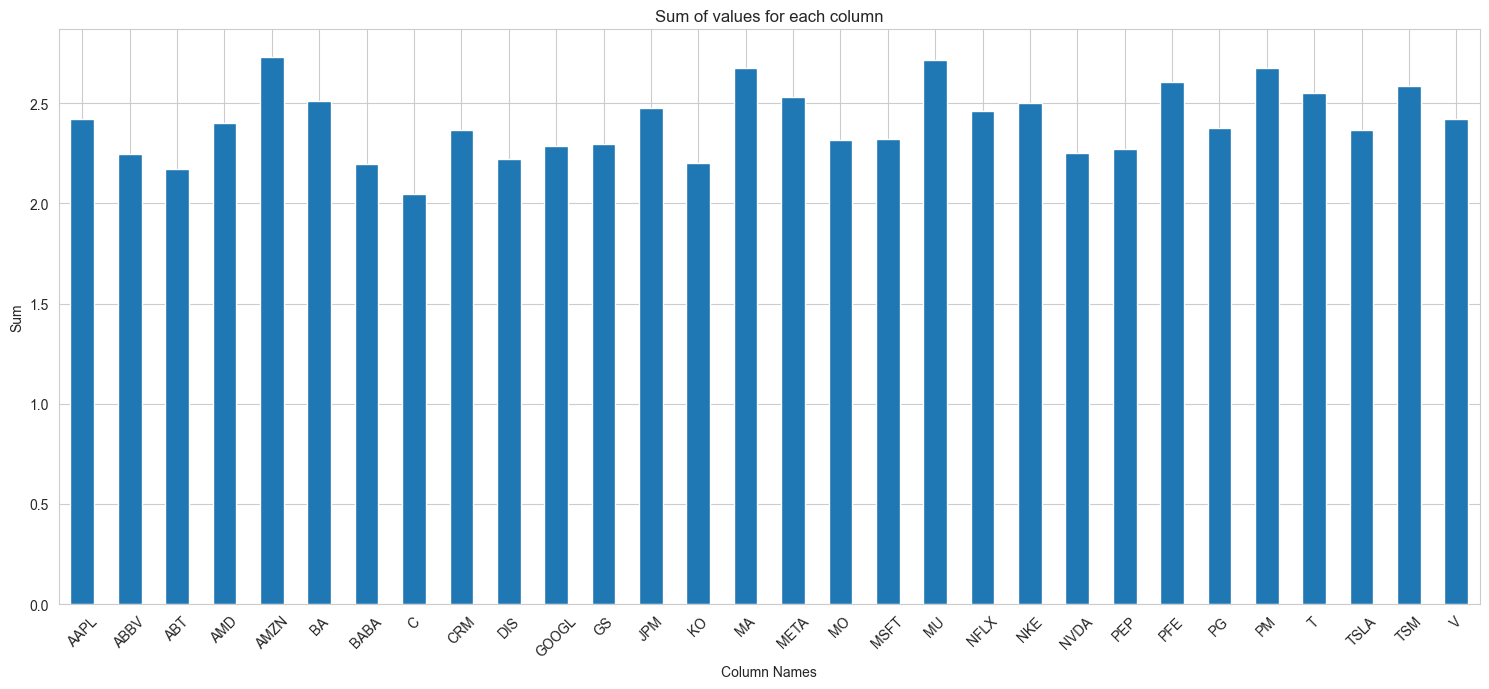

In [118]:
import matplotlib.pyplot as plt

# Sum up all values in each column
column_sums = tics.sum()

# Visualize the summed values
column_sums.plot(kind='bar', figsize=(15, 7))
plt.title('Sum of values for each column')
plt.ylabel('Sum')
plt.xlabel('Column Names')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [39]:
import matplotlib
#matplotlib.use('Agg')  # or another appropriate backend like 'Qt5Agg'
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

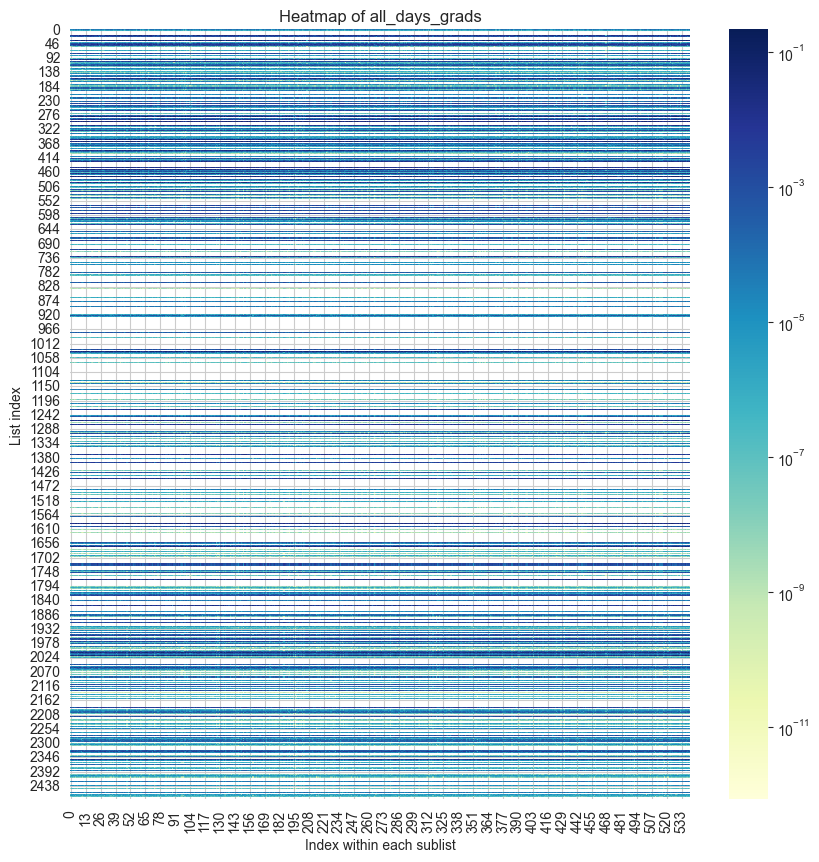

In [40]:
# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(all_days_grads, cmap="YlGnBu", cbar=True, norm=LogNorm())

# Display the plot
plt.title('Heatmap of all_days_grads')
#plt.yscale("log")
plt.xlabel('Index within each sublist')
plt.ylabel('List index')
plt.savefig('Heatmap.pdf')

In [ ]:
len(state)

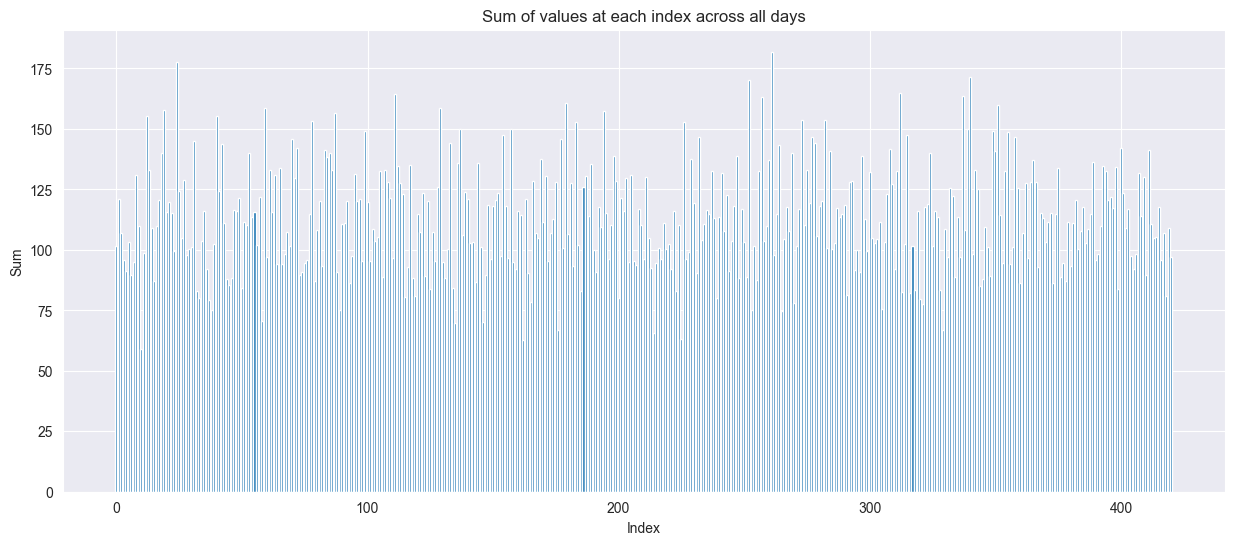

In [42]:
sums = [sum(day[i] for day in all_days_grads) for i in range(421)]
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.bar(range(421), sums)
plt.title('Sum of values at each index across all days')
plt.xlabel('Index')
plt.ylabel('Sum')
plt.show()


Wichtige Tage
für jeden Tag, d.h. für jede Liste in der Liste, wird die Summe gebildet
Am Ende haben wir ein Array, das genau so lang ist wie der index, also unser Datum.
Darin sind Summen enthalten.



# Sum the values in each sublist
sums = [sum(sublist) for sublist in all_days_grads]

# Find the top 20 indexes with the highest sums
top_20_indexes = sorted(range(len(sums)), key=lambda i: sums[i], reverse=True)[:len(all_days_grads)]

top_20_indexes

top_20_sums = [sums[i] for i in top_20_indexes]

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(range(len(all_days_grads)), top_20_sums, color='blue')
plt.xticks(range(len(all_days_grads)), top_20_indexes, rotation=45)
plt.xlabel('Indexes')
plt.ylabel('Sum')
plt.title('Top 20 Indexes with Highest Sums')
plt.tight_layout()
plt.show()

# Drop duplicates based on index to get a unique mapping of index to date
df_unique_dates = train.drop_duplicates(subset='date')
# Extract dates corresponding to the top 20 indexes
top_20_dates = df_unique_dates.loc[top_20_indexes, 'date'].values

# Create a dictionary mapping indexes to dates
index_to_date_dict = dict(zip(top_20_indexes, top_20_dates))

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(range(len(all_days_grads)), top_20_sums, color='blue')
plt.xticks(range(len(all_days_grads)), top_20_dates, rotation=45)
plt.xlabel('Dates')
plt.ylabel('Sum')
plt.title('Top 20 Dates with Highest Sums')
plt.tight_layout()
plt.show()

train

top_20_dates


# Drop duplicates based on index to get a unique mapping of index to date
df_unique_dates = train.drop_duplicates(subset='date')

# Sum the values in each sublist
sums = [sum(sublist) for sublist in all_days_grads]

# Define the number of bins
num_bins = int(len(all_days_grads)/7)

# Create bins for sums
bins = np.linspace(min(sums), max(sums), num_bins)
hist, bin_edges = np.histogram(sums, bins=bins)

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align="edge", color='blue')
plt.xlabel('Sum Range')
plt.ylabel('Count')
plt.title('Histogram of Sums')
plt.tight_layout()
plt.show()

In [66]:
df = train.copy()
df['date'] = pd.to_datetime(df['date']).dt.date


In [67]:
df

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,close_30_sma,close_60_sma,turbulence,vix,stocktwitsPosts,stocktwitsLikes,stocktwitsImpressions,stocktwitsSentiment,random,change
index,,,,,,,,,,,,,,,,,,,,,
0,2021-11-24,64.016138,63.988587,64.138571,64.165348,36.200417,AAPL,186.666667,165.712679,63.525899,...,64.562223,64.515546,20.000000,161.582472,42.666667,50.877193,47.542370,126.571143,206.266471,118.382430
0,2021-11-24,34.827192,34.786757,34.875852,34.798301,22.318159,C,186.666667,165.712679,63.525899,...,34.892177,34.836590,20.000000,161.582472,20.000000,20.000000,20.000076,101.033996,39.722360,89.172281
0,2021-11-24,63.735181,63.672157,63.905794,63.810473,21.514435,JPM,186.666667,165.712679,63.525899,...,64.203686,64.156902,20.000000,161.582472,20.888889,20.701754,26.727835,105.423009,77.336659,90.847267
0,2021-11-24,130.541469,130.440677,130.775316,130.724732,20.361236,GS,186.666667,165.712679,63.525899,...,131.808344,131.781861,20.000000,161.582472,20.222222,20.000000,20.000152,95.234946,94.160304,148.475247
0,2021-11-24,59.892214,59.926327,60.099197,60.069891,21.520549,GOOGL,186.666667,165.712679,63.525899,...,60.424511,60.376591,20.000000,161.582472,20.444444,20.467836,20.021326,117.011256,194.675854,117.319664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2481,2023-04-26,33.792582,33.865849,33.862281,33.987337,26.899892,MU,53.333333,163.749029,34.202601,...,34.108566,34.311505,21.616267,89.575858,20.000000,20.000000,20.000076,20.000000,219.860261,82.714771
2481,2023-04-26,72.236463,72.157490,72.275134,72.210196,20.708630,PEP,53.333333,169.542039,72.218273,...,72.194686,71.767163,21.616267,89.575858,20.222222,20.000000,22.730501,120.000000,80.330793,143.779791
2481,2023-04-26,34.886468,34.858618,34.961660,34.929742,22.787461,KO,53.333333,165.624683,34.885209,...,35.125097,34.978048,21.616267,89.575858,20.222222,20.000000,20.776658,129.360000,64.741406,94.478270


In [31]:
best_days = pd.DataFrame(all_days_grads)
best_days

,0,1,2,3,4,5,6,7,8,9,...,531,532,533,534,535,536,537,538,539,540
0,1.199955e-03,0.007527,2.548303e-03,6.621065e-04,3.280817e-03,0.000153,6.887335e-04,3.276230e-03,0.001388,4.573338e-03,...,4.057718e-03,6.621523e-03,3.940221e-04,0.001179,0.001632,0.002591,2.471361e-03,1.383455e-03,3.545431e-03,3.168833e-03
1,3.785917e-07,0.000003,9.091225e-07,9.834691e-07,9.203815e-08,0.000002,8.394102e-07,3.892275e-07,0.000002,6.874574e-07,...,1.995029e-07,8.696333e-07,1.887773e-08,0.000002,0.000001,0.000001,5.191810e-07,8.969224e-07,1.169609e-06,1.082006e-06
2,7.645065e-03,0.000659,7.760478e-03,8.017940e-03,3.001556e-03,0.012798,1.857347e-02,1.802060e-03,0.002952,3.613254e-03,...,2.424012e-03,3.368587e-03,2.004542e-02,0.011928,0.008087,0.010571,1.713220e-02,7.661199e-04,1.784527e-02,2.288787e-03
3,2.919835e-06,0.000007,8.716936e-06,3.130333e-06,2.231498e-06,0.000002,1.991921e-06,2.374820e-06,0.000007,3.142635e-06,...,5.642642e-06,9.244450e-07,5.337705e-06,0.000004,0.000005,0.000001,7.438046e-06,4.542542e-06,1.629073e-07,9.758633e-07
4,8.760929e-03,0.038255,5.101008e-03,2.012497e-02,7.817661e-04,0.006551,9.702379e-03,1.437607e-02,0.006153,2.808519e-02,...,5.890694e-03,2.223138e-02,3.271456e-02,0.022548,0.030885,0.018994,5.674512e-02,1.142234e-02,5.386917e-02,2.047472e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,9.856908e-08,0.000022,1.311438e-05,1.864961e-05,1.176109e-05,0.000001,2.331583e-06,1.856850e-05,0.000008,1.488260e-05,...,2.131604e-05,1.056209e-06,1.680323e-05,0.000011,0.000009,0.000009,7.640796e-06,2.186121e-05,4.043528e-06,1.074635e-05
2478,5.051242e-03,0.008564,7.159503e-03,8.782066e-04,7.073743e-04,0.008714,9.217665e-03,4.486210e-04,0.008134,2.406676e-03,...,3.554390e-03,3.942124e-03,2.465171e-03,0.002668,0.007640,0.008297,1.394524e-02,1.003828e-03,1.078669e-04,9.631945e-03
2479,7.105005e-02,0.292430,1.231691e-01,2.219783e-01,2.237585e-01,0.153813,9.595384e-02,1.375939e-01,0.132157,6.743296e-02,...,2.279727e-01,1.189887e-01,2.629684e-01,0.053162,0.075179,0.135460,1.927880e-02,2.693443e-01,2.652520e-01,1.669882e-01
2480,2.923269e-03,0.004624,1.320521e-03,2.055391e-03,3.414806e-03,0.001751,3.098573e-04,1.272742e-03,0.000727,2.325608e-03,...,8.404756e-04,6.317590e-04,2.875800e-03,0.000778,0.002294,0.004925,6.761357e-04,4.373633e-03,5.788362e-03,8.005189e-04


In [32]:
best_days = pd.DataFrame(all_days_grads)
best_days.set_index(train.date.unique(), inplace=True)
best_days

,0,1,2,3,4,5,6,7,8,9,...,531,532,533,534,535,536,537,538,539,540
2021-11-24 14:00:00,1.199955e-03,0.007527,2.548303e-03,6.621065e-04,3.280817e-03,0.000153,6.887335e-04,3.276230e-03,0.001388,4.573338e-03,...,4.057718e-03,6.621523e-03,3.940221e-04,0.001179,0.001632,0.002591,2.471361e-03,1.383455e-03,3.545431e-03,3.168833e-03
2021-11-24 15:00:00,3.785917e-07,0.000003,9.091225e-07,9.834691e-07,9.203815e-08,0.000002,8.394102e-07,3.892275e-07,0.000002,6.874574e-07,...,1.995029e-07,8.696333e-07,1.887773e-08,0.000002,0.000001,0.000001,5.191810e-07,8.969224e-07,1.169609e-06,1.082006e-06
2021-11-26 09:00:00,7.645065e-03,0.000659,7.760478e-03,8.017940e-03,3.001556e-03,0.012798,1.857347e-02,1.802060e-03,0.002952,3.613254e-03,...,2.424012e-03,3.368587e-03,2.004542e-02,0.011928,0.008087,0.010571,1.713220e-02,7.661199e-04,1.784527e-02,2.288787e-03
2021-11-26 10:00:00,2.919835e-06,0.000007,8.716936e-06,3.130333e-06,2.231498e-06,0.000002,1.991921e-06,2.374820e-06,0.000007,3.142635e-06,...,5.642642e-06,9.244450e-07,5.337705e-06,0.000004,0.000005,0.000001,7.438046e-06,4.542542e-06,1.629073e-07,9.758633e-07
2021-11-26 11:00:00,8.760929e-03,0.038255,5.101008e-03,2.012497e-02,7.817661e-04,0.006551,9.702379e-03,1.437607e-02,0.006153,2.808519e-02,...,5.890694e-03,2.223138e-02,3.271456e-02,0.022548,0.030885,0.018994,5.674512e-02,1.142234e-02,5.386917e-02,2.047472e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25 13:00:00,9.856908e-08,0.000022,1.311438e-05,1.864961e-05,1.176109e-05,0.000001,2.331583e-06,1.856850e-05,0.000008,1.488260e-05,...,2.131604e-05,1.056209e-06,1.680323e-05,0.000011,0.000009,0.000009,7.640796e-06,2.186121e-05,4.043528e-06,1.074635e-05
2023-04-25 14:00:00,5.051242e-03,0.008564,7.159503e-03,8.782066e-04,7.073743e-04,0.008714,9.217665e-03,4.486210e-04,0.008134,2.406676e-03,...,3.554390e-03,3.942124e-03,2.465171e-03,0.002668,0.007640,0.008297,1.394524e-02,1.003828e-03,1.078669e-04,9.631945e-03
2023-04-25 15:00:00,7.105005e-02,0.292430,1.231691e-01,2.219783e-01,2.237585e-01,0.153813,9.595384e-02,1.375939e-01,0.132157,6.743296e-02,...,2.279727e-01,1.189887e-01,2.629684e-01,0.053162,0.075179,0.135460,1.927880e-02,2.693443e-01,2.652520e-01,1.669882e-01
2023-04-26 09:00:00,2.923269e-03,0.004624,1.320521e-03,2.055391e-03,3.414806e-03,0.001751,3.098573e-04,1.272742e-03,0.000727,2.325608e-03,...,8.404756e-04,6.317590e-04,2.875800e-03,0.000778,0.002294,0.004925,6.761357e-04,4.373633e-03,5.788362e-03,8.005189e-04


In [33]:
best_days.index

Index(['2021-11-24 14:00:00', '2021-11-24 15:00:00', '2021-11-26 09:00:00',
       '2021-11-26 10:00:00', '2021-11-26 11:00:00', '2021-11-26 12:00:00',
       '2021-11-26 13:00:00', '2021-11-26 14:00:00', '2021-11-26 15:00:00',
       '2021-11-29 09:00:00',
       ...
       '2023-04-24 15:00:00', '2023-04-25 09:00:00', '2023-04-25 10:00:00',
       '2023-04-25 11:00:00', '2023-04-25 12:00:00', '2023-04-25 13:00:00',
       '2023-04-25 14:00:00', '2023-04-25 15:00:00', '2023-04-26 09:00:00',
       '2023-04-26 10:00:00'],
      dtype='object', length=2482)

In [34]:
best_days = pd.DataFrame(all_days_grads)
best_days.set_index(train.date.unique(), inplace=True)
best_days['date'] = best_days.index
best_days['date'] = pd.to_datetime(best_days['date']).dt.date

In [35]:
best_days

,0,1,2,3,4,5,6,7,8,9,...,532,533,534,535,536,537,538,539,540,date
2021-11-24 14:00:00,1.199955e-03,0.007527,2.548303e-03,6.621065e-04,3.280817e-03,0.000153,6.887335e-04,3.276230e-03,0.001388,4.573338e-03,...,6.621523e-03,3.940221e-04,0.001179,0.001632,0.002591,2.471361e-03,1.383455e-03,3.545431e-03,3.168833e-03,2021-11-24
2021-11-24 15:00:00,3.785917e-07,0.000003,9.091225e-07,9.834691e-07,9.203815e-08,0.000002,8.394102e-07,3.892275e-07,0.000002,6.874574e-07,...,8.696333e-07,1.887773e-08,0.000002,0.000001,0.000001,5.191810e-07,8.969224e-07,1.169609e-06,1.082006e-06,2021-11-24
2021-11-26 09:00:00,7.645065e-03,0.000659,7.760478e-03,8.017940e-03,3.001556e-03,0.012798,1.857347e-02,1.802060e-03,0.002952,3.613254e-03,...,3.368587e-03,2.004542e-02,0.011928,0.008087,0.010571,1.713220e-02,7.661199e-04,1.784527e-02,2.288787e-03,2021-11-26
2021-11-26 10:00:00,2.919835e-06,0.000007,8.716936e-06,3.130333e-06,2.231498e-06,0.000002,1.991921e-06,2.374820e-06,0.000007,3.142635e-06,...,9.244450e-07,5.337705e-06,0.000004,0.000005,0.000001,7.438046e-06,4.542542e-06,1.629073e-07,9.758633e-07,2021-11-26
2021-11-26 11:00:00,8.760929e-03,0.038255,5.101008e-03,2.012497e-02,7.817661e-04,0.006551,9.702379e-03,1.437607e-02,0.006153,2.808519e-02,...,2.223138e-02,3.271456e-02,0.022548,0.030885,0.018994,5.674512e-02,1.142234e-02,5.386917e-02,2.047472e-02,2021-11-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25 13:00:00,9.856908e-08,0.000022,1.311438e-05,1.864961e-05,1.176109e-05,0.000001,2.331583e-06,1.856850e-05,0.000008,1.488260e-05,...,1.056209e-06,1.680323e-05,0.000011,0.000009,0.000009,7.640796e-06,2.186121e-05,4.043528e-06,1.074635e-05,2023-04-25
2023-04-25 14:00:00,5.051242e-03,0.008564,7.159503e-03,8.782066e-04,7.073743e-04,0.008714,9.217665e-03,4.486210e-04,0.008134,2.406676e-03,...,3.942124e-03,2.465171e-03,0.002668,0.007640,0.008297,1.394524e-02,1.003828e-03,1.078669e-04,9.631945e-03,2023-04-25
2023-04-25 15:00:00,7.105005e-02,0.292430,1.231691e-01,2.219783e-01,2.237585e-01,0.153813,9.595384e-02,1.375939e-01,0.132157,6.743296e-02,...,1.189887e-01,2.629684e-01,0.053162,0.075179,0.135460,1.927880e-02,2.693443e-01,2.652520e-01,1.669882e-01,2023-04-25
2023-04-26 09:00:00,2.923269e-03,0.004624,1.320521e-03,2.055391e-03,3.414806e-03,0.001751,3.098573e-04,1.272742e-03,0.000727,2.325608e-03,...,6.317590e-04,2.875800e-03,0.000778,0.002294,0.004925,6.761357e-04,4.373633e-03,5.788362e-03,8.005189e-04,2023-04-26


In [36]:
best_days.to_csv('gradients.csv', index=False)

In [37]:
plot_data= best_days.groupby('date').mean().sum(axis=1)
plot_data.values

array([  0.875731 ,   6.8074937,  62.01908  ,  23.556904 ,  13.169268 ,
         2.8935127,   3.2356148,  31.41931  ,  28.092484 ,  20.087646 ,
        38.783264 ,  65.61805  ,  31.052631 ,  25.457943 ,   4.890319 ,
        21.155762 ,  15.893914 ,  20.860031 ,   5.0312147,   8.009255 ,
        21.82481  ,   8.660948 ,   4.7187653,  15.006365 ,  44.35568  ,
         9.724962 ,  26.281729 ,   8.489876 ,  12.594185 ,   5.394629 ,
        15.718521 ,  13.409701 ,   5.9290357,  36.728806 ,   9.892114 ,
        14.194804 ,  14.232415 ,  11.24255  ,  23.208015 ,  23.846552 ,
        17.230585 ,  26.079906 ,  13.978058 ,   9.807065 ,   6.633662 ,
        17.259684 ,  11.069449 ,  16.791048 ,  12.503719 ,  77.00101  ,
        38.577526 ,  25.454777 ,   5.35046  ,  45.28927  ,  20.069496 ,
         5.6868143,  20.781624 ,  28.160898 ,   4.0281086,  23.96817  ,
         3.801087 ,   8.93542  ,  22.020828 ,   7.844922 ,   7.856592 ,
         9.08768  ,  43.38488  ,   8.071135 ,  12.728284 ,   8.4

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = plot_data.index
students = plot_data.values
ax.bar(langs,students)
plt.show()

C:\Users\potap\AppData\Local\Temp\ipykernel_4792\1349838603.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


# Top Tage

In [39]:
sorted_df = pd.DataFrame({'date':plot_data.index, 'values':plot_data.values})

In [40]:
sorted_df

,date,values
0,2021-11-24,0.875731
1,2021-11-26,6.807494
2,2021-11-29,62.019081
3,2021-11-30,23.556904
4,2021-12-01,13.169268
...,...,...
351,2023-04-20,7.661361
352,2023-04-21,14.843298
353,2023-04-24,26.971466
354,2023-04-25,17.364002


In [41]:
top_10 = sorted_df.sort_values(by=['values'], ascending=False).head(10)

In [42]:
best_gradients= best_days.groupby('date').mean()

In [43]:
best_gradients

,0,1,2,3,4,5,6,7,8,9,...,531,532,533,534,535,536,537,538,539,540
date,,,,,,,,,,,,,,,,,,,,,
2021-11-24,0.000600,0.003765,0.001275,0.000332,0.001640,0.000077,0.000345,0.001638,0.000695,0.002287,...,0.002029,0.003311,0.000197,0.000591,0.000817,0.001296,0.001236,0.000692,0.001773,0.001585
2021-11-26,0.004759,0.013269,0.010836,0.005298,0.005343,0.010572,0.016574,0.015705,0.009627,0.023472,...,0.008856,0.015986,0.014500,0.013160,0.014154,0.007987,0.021794,0.009306,0.022991,0.008175
2021-11-29,0.172766,0.157202,0.204298,0.156822,0.133750,0.129299,0.148031,0.111548,0.326571,0.057584,...,0.265704,0.152203,0.209916,0.067081,0.073621,0.035879,0.104793,0.018951,0.087694,0.211731
2021-11-30,0.032367,0.055365,0.023280,0.031363,0.046862,0.045839,0.010310,0.034551,0.042152,0.037930,...,0.029682,0.062286,0.027383,0.032156,0.071843,0.015995,0.062586,0.044661,0.061739,0.083923
2021-12-01,0.041667,0.032053,0.016817,0.017997,0.022057,0.030470,0.035890,0.021129,0.028996,0.013752,...,0.020194,0.015141,0.022465,0.032472,0.039504,0.022634,0.028283,0.019335,0.039589,0.019372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-20,0.005791,0.016126,0.009756,0.019431,0.017179,0.012244,0.010546,0.008053,0.011973,0.013770,...,0.024908,0.007697,0.011655,0.009433,0.008377,0.043766,0.008411,0.005568,0.008209,0.009343
2023-04-21,0.028437,0.026353,0.022119,0.031936,0.027894,0.039480,0.017271,0.021747,0.054305,0.013823,...,0.028548,0.044511,0.026018,0.009043,0.030465,0.011927,0.038839,0.014739,0.040935,0.033182
2023-04-24,0.035920,0.059133,0.048150,0.020811,0.044768,0.073858,0.036216,0.029519,0.039702,0.056909,...,0.032406,0.088754,0.031970,0.070669,0.088382,0.030148,0.080102,0.067327,0.052685,0.058352


# Features von Top Tag

In [44]:
best_gradients.loc[best_gradients.index == top_10['date'].values[0]]

,0,1,2,3,4,5,6,7,8,9,...,531,532,533,534,535,536,537,538,539,540
date,,,,,,,,,,,,,,,,,,,,,
2023-03-09,0.070434,0.209434,0.120849,0.07771,0.157148,0.132479,0.101997,0.189441,0.146097,0.132932,...,0.172581,0.158151,0.121267,0.145,0.292839,0.109108,0.177168,0.137767,0.31651,0.273393


# Top Feature


In [109]:
aggregated = best_days.groupby('date').mean()

Index([2021-11-24, 2021-11-26, 2021-11-29, 2021-11-30, 2021-12-01, 2021-12-02,
       2021-12-03, 2021-12-06, 2021-12-07, 2021-12-08,
       ...
       2023-04-13, 2023-04-14, 2023-04-17, 2023-04-18, 2023-04-19, 2023-04-20,
       2023-04-21, 2023-04-24, 2023-04-25, 2023-04-26],
      dtype='object', name='date', length=356)

# Top Features

In [46]:
best_days

,0,1,2,3,4,5,6,7,8,9,...,532,533,534,535,536,537,538,539,540,date
2021-11-24 14:00:00,1.199955e-03,0.007527,2.548303e-03,6.621065e-04,3.280817e-03,0.000153,6.887335e-04,3.276230e-03,0.001388,4.573338e-03,...,6.621523e-03,3.940221e-04,0.001179,0.001632,0.002591,2.471361e-03,1.383455e-03,3.545431e-03,3.168833e-03,2021-11-24
2021-11-24 15:00:00,3.785917e-07,0.000003,9.091225e-07,9.834691e-07,9.203815e-08,0.000002,8.394102e-07,3.892275e-07,0.000002,6.874574e-07,...,8.696333e-07,1.887773e-08,0.000002,0.000001,0.000001,5.191810e-07,8.969224e-07,1.169609e-06,1.082006e-06,2021-11-24
2021-11-26 09:00:00,7.645065e-03,0.000659,7.760478e-03,8.017940e-03,3.001556e-03,0.012798,1.857347e-02,1.802060e-03,0.002952,3.613254e-03,...,3.368587e-03,2.004542e-02,0.011928,0.008087,0.010571,1.713220e-02,7.661199e-04,1.784527e-02,2.288787e-03,2021-11-26
2021-11-26 10:00:00,2.919835e-06,0.000007,8.716936e-06,3.130333e-06,2.231498e-06,0.000002,1.991921e-06,2.374820e-06,0.000007,3.142635e-06,...,9.244450e-07,5.337705e-06,0.000004,0.000005,0.000001,7.438046e-06,4.542542e-06,1.629073e-07,9.758633e-07,2021-11-26
2021-11-26 11:00:00,8.760929e-03,0.038255,5.101008e-03,2.012497e-02,7.817661e-04,0.006551,9.702379e-03,1.437607e-02,0.006153,2.808519e-02,...,2.223138e-02,3.271456e-02,0.022548,0.030885,0.018994,5.674512e-02,1.142234e-02,5.386917e-02,2.047472e-02,2021-11-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25 13:00:00,9.856908e-08,0.000022,1.311438e-05,1.864961e-05,1.176109e-05,0.000001,2.331583e-06,1.856850e-05,0.000008,1.488260e-05,...,1.056209e-06,1.680323e-05,0.000011,0.000009,0.000009,7.640796e-06,2.186121e-05,4.043528e-06,1.074635e-05,2023-04-25
2023-04-25 14:00:00,5.051242e-03,0.008564,7.159503e-03,8.782066e-04,7.073743e-04,0.008714,9.217665e-03,4.486210e-04,0.008134,2.406676e-03,...,3.942124e-03,2.465171e-03,0.002668,0.007640,0.008297,1.394524e-02,1.003828e-03,1.078669e-04,9.631945e-03,2023-04-25
2023-04-25 15:00:00,7.105005e-02,0.292430,1.231691e-01,2.219783e-01,2.237585e-01,0.153813,9.595384e-02,1.375939e-01,0.132157,6.743296e-02,...,1.189887e-01,2.629684e-01,0.053162,0.075179,0.135460,1.927880e-02,2.693443e-01,2.652520e-01,1.669882e-01,2023-04-25
2023-04-26 09:00:00,2.923269e-03,0.004624,1.320521e-03,2.055391e-03,3.414806e-03,0.001751,3.098573e-04,1.272742e-03,0.000727,2.325608e-03,...,6.317590e-04,2.875800e-03,0.000778,0.002294,0.004925,6.761357e-04,4.373633e-03,5.788362e-03,8.005189e-04,2023-04-26


In [47]:
data = train.loc[0, :]

data[INDICATORS[0]].values.tolist()

[165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158,
 165.71267877055158]

In [ ]:
all_days_grads = []
for day in range(len((train.date.unique()))): # len((train.date.unique()))
   data = train.loc[day, :]

   state = (
    [50]
    + data.close.values.tolist()
    + num_stock_shares
    + sum(
        (
            data[tech].values.tolist()
            for tech in INDICATORS
        ),
        [],
    )
    + sum(
    (
        data[sent].values.tolist()
        for sent in SENTIMENT
    ),
    [],
)
    + data.change.values.tolist()
    + data.volume.values.tolist())

   #print(state)
   xs = tf.convert_to_tensor([state])
   with tf.GradientTape() as tape:
        tape.watch(xs)
        pred = model_loaded(xs)
        grads = tape.gradient(pred, xs)
   grads = grads.numpy()
   abs_grads_sum = np.sum(np.abs(grads), axis=0)
   all_days_grads.append(abs_grads_sum)